In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pylab as plt
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [52]:
def import_files(path):
    struc = pd.DataFrame(columns =["radiation_level", "path","code_file","group"])
    read = os.walk(path)
    for root, dirs, files in read:
        for name in files:
            if name.endswith(".csv"):
                #print(name)
                radiation = name.split("gy")
                [_,group,_] = name.split("_") 
                filepath = path+ '/' + name
                code_file = name[:-4] #removing suffix
                
                struc = struc.append({"radiation_level" : int(radiation[0]), "path" : filepath, "code_file" : code_file, "group" : group}, ignore_index=True)
                
    return struc

In [53]:
def str_to_numpy(input_str):
    """
    str_to_numpy is used to parse the columns "input" and "output" of the dataset csv files.
    It converts a string representing an array of cells to a numpy array containing strings
    which are the names of these cells.
    """
    process_str = input_str.replace("[", "")
    process_str = process_str.replace("'", "")
    process_str = process_str.replace(" ", "")
    process_str = process_str.replace("]", "")
    if(process_str != ""):
        process_str = process_str.split(",")
        output_array = np.asarray(process_str, dtype=str)
    else:
        output_array = np.asarray([], dtype=str)
    return output_array

In [54]:
def root_cell_test(row, root): #Tests if the row corresponds to the root cell
    for c in row.input:
        if str(c).startswith(root):
            return True
    return False

def obtain_roots(experience):
    roots = experience.loc[experience.event == 'begin'].output 
    root_cells = []
    for cell in roots:
        root_cells.append(str(cell[0]))
    return(root_cells)

def cells_to_trees(experience, file_code=""): #experience is a DataFrame
    #Select root cells in experience
    root_cells = obtain_roots(experience)

    #Creation of a tree corresponding to the experience
    trees = pd.DataFrame(columns = ["root_cell", "time","event","input","output"])
    for root in root_cells:
        #exp_bis = experience.loc[experience.event != "begin"]
        f = lambda row : root_cell_test(row, root)
        root_cell = experience[experience.apply(f, axis=1)]
        root_cell.insert(loc=0, column='root_cell', value=root+"_"+file_code, allow_duplicates=True)
        #trees = trees.append(root_cell)
        root_cell=root_cell.sort_values(by='time')
        trees = pd.concat([trees, root_cell], ignore_index=True, sort=False)
    return trees

In [55]:
path = '../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv'
file = path + "/0gy_n1_201104.nd2u2510Gy1A.csv"
experience = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy})
trees = cells_to_trees(experience)
trees
root_cells = obtain_roots(experience)

features = pd.DataFrame({'root_cells' : root_cells})
features
trees[trees.root_cell == "C1"]

experience



,time,event,input,output
0,0,begin,[],[C1]
1,66,div,[C1],"[C1.1, C1.2]"
2,238,div,[C1.1],"[C1.1.1, C1.1.2]"
3,386,div,[C1.1.1],"[C1.1.1.1, C1.1.1.2]"
4,432,end,[C1.1.1.1],[]
...,...,...,...,...
120,432,end,[C9.2.1.1],[]
121,432,end,[C9.2.1.2],[]
122,350,div,[C9.2.2],"[C9.2.2.1, C9.2.2.2]"
123,432,end,[C9.2.2.1],[]


Features à rajouter :   
    - 




In [56]:
def t_moy_div(tree):
    
    tree['temp'] = trees.loc[(trees.event=='div')].time - trees.loc[(trees.event=='div')].time.shift()
    
    time = trees.loc[(trees.event=='div')].temp.avg()

    return(time)

In [57]:
def cell_lineage_exp(experience, file_code=""):

    trees = cells_to_trees(experience, file_code)

    root_cells = obtain_roots(experience)
    for i in range(len(root_cells)):
        root_cells[i] += "_" + file_code
    features = pd.DataFrame({'root_cells' : root_cells})
    
    features['nb_divisions'] = features['root_cells'].map(trees.loc[trees.event=='div'].groupby(['root_cell']).root_cell.count())
    features['nb_fusions'] = features['root_cells'].map(trees.loc[trees.event=='fusion'].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    features['nb_deaths'] = features['root_cells'].map(trees.loc[trees.event=='death'].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    
    features['cells_alive_at_end'] = features['root_cells'].map(trees.loc[trees.event=='end'].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    
    features['nb_divisions_d1'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 144)].groupby(['root_cell']).root_cell.count())
    features['nb_divisions_d2'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 2*144) & (trees.time > 144)].groupby(['root_cell']).root_cell.count())
    features['nb_divisions_d3'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 3*144) & (trees.time > 2*144)].groupby(['root_cell']).root_cell.count())
    features['nb_divisions_d4'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 4*144) & (trees.time > 3*144)].groupby(['root_cell']).root_cell.count())

    features= features.fillna(0)


    features['prop_cells_alive'] = features.cells_alive_at_end / (features.nb_divisions + 1) #pas forcément utile -> combinaison linéaire 
    
    features['nb_deaths_d1'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 144)].groupby(['root_cell']).root_cell.count())
    features['nb_deaths_d2'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 2*144) & (trees.time > 144)].groupby(['root_cell']).root_cell.count())
    features['nb_deaths_d3'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 3*144) & (trees.time > 2*144)].groupby(['root_cell']).root_cell.count())
    features['nb_deaths_d4'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 4*144) & (trees.time > 3*144)].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)


    features['nb_fusions_d1'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 144)].groupby(['root_cell']).root_cell.count())
    features['nb_fusions_d2'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 2*144) & (trees.time > 144)].groupby(['root_cell']).root_cell.count())
    features['nb_fusions_d3'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 3*144) & (trees.time > 2*144)].groupby(['root_cell']).root_cell.count())
    features['nb_fusions_d4'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 4*144) & (trees.time > 3*144)].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    features['cells_alive_d1'] = features.nb_divisions_d1 + 1 - features.nb_deaths_d1 - features.nb_fusions_d1
    features['cells_alive_d2'] = features.cells_alive_d1 +features.nb_divisions_d2 - features.nb_deaths_d2 - features.nb_fusions_d2
    features['cells_alive_d3'] = features.cells_alive_d2 +features.nb_divisions_d3 - features.nb_deaths_d3 - features.nb_fusions_d3
    features['cells_alive_d4'] = features.cells_alive_d3 +features.nb_divisions_d4  - features.nb_deaths_d4 - features.nb_fusions_d4
    features= features.fillna(0)

    #abnormal divisions
    pdlen = lambda row : (len(row.output) > 2)

    features['nb_abnormal_div'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.apply(pdlen, axis=1))].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    #Time between 2 divisions
    # Should select event div for each tree (by root cell) 
    trees['temp'] = trees.loc[(trees.event=='div')].time - trees.loc[(trees.event=='div')].time.shift() # Not ok !
    features['avg_div_time'] = trees.loc[(trees.event=='div')].temp.mean() # Not ok !
    #del trees.temp


    return features

    

In [58]:
trees.head()

#pdlen = lambda row : (len(row.output) > 2)

#trees[trees.apply(pdlen, axis=1)]

,root_cell,time,event,input,output
0,C1_,66,div,[C1],"[C1.1, C1.2]"
1,C1_,238,div,[C1.1],"[C1.1.1, C1.1.2]"
2,C1_,259,div,[C1.2],"[C1.2.1, C1.2.2]"
3,C1_,364,div,[C1.2.1],"[C1.2.1.1, C1.2.1.2]"
4,C1_,386,div,[C1.1.1],"[C1.1.1.1, C1.1.1.2]"


In [59]:
files = import_files(path)

files

,radiation_level,path,code_file,group
0,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n3_07-06-2021-10Gy-u251-5B,n3
1,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n2_2021n210Gy6C,n2
2,2,../input/glioblastoma-radiosensitivity-dataset...,2gy_n3_2021-04-2Gy-2C,n3
3,4,../input/glioblastoma-radiosensitivity-dataset...,4gy_n1_160930.nd2u2514gyp1,n1
4,15,../input/glioblastoma-radiosensitivity-dataset...,15gy_n2_2021N215GY5B,n2
...,...,...,...,...
176,2,../input/glioblastoma-radiosensitivity-dataset...,2gy_n3_2021-04-2Gy-6A,n3
177,15,../input/glioblastoma-radiosensitivity-dataset...,15gy_n3_2021-N3-15Gy-5B,n3
178,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n3_07-06-2021-10Gy-u251-2C,n3
179,10,../input/glioblastoma-radiosensitivity-dataset...,10gy_n2_2021n210Gy4A,n2


In [60]:
def cell_lineage(path):

    files = import_files(path)

    cl = pd.DataFrame()

    for file in files.itertuples():

        file_path = path + "/" + file.code_file + ".csv"

        exp = pd.read_csv(file_path, converters = {"input" : str_to_numpy, "output" : str_to_numpy})

        feature = cell_lineage_exp(exp, file.code_file)
        print(file.code_file)

        feature['radiation_lvl'] = file.radiation_level
        feature['exp_group'] = file.group
        
        cl = cl.append(feature, ignore_index=True)


    return cl
    

In [61]:
cl = cell_lineage(path)


10gy_n3_07-06-2021-10Gy-u251-5B
10gy_n2_2021n210Gy6C
2gy_n3_2021-04-2Gy-2C
4gy_n1_160930.nd2u2514gyp1
15gy_n2_2021N215GY5B
2gy_n3_2021-04-2Gy-5B
15gy_n2_2021N215GY2B
2gy_n3_2021-04-2Gy-3C
15gy_n2_2021N215GY3B
8gy_n1_160930.nd2u2518gyp4
2gy_n2_201127.nd2u2512gyB4B
0gy_n1_2020 11 04 .0Gy B2A
15gy_n3_2021-N3-15Gy-4A
4gy_n1_160930.nd2u2514gyp2
0gy_n2_2021 03 12 0Gy 12B
0gy_n2_202103120Gyu25112C
10gy_n1_160930.nd2u25110gyp3
0gy_n1_2020 11 04 0Gy A2B
0gy_n1_201104.nd2u2510GyA3A
15gy_n2_2021N215GY6A
0gy_n3_n3 2021 0Gy 2A
2gy_n1_160930.nd2u2512gyp4
8gy_n3_2021 11 11  8Gy C3B
8gy_n1_2020 11 04 A3 0Gy
15gy_n3_2021-N3-15Gy-2A
15gy_n3_2021-N3-15Gy-4C
10gy_n3_07-06-2021-10Gy-u251-4B
4gy_n3_2020 16 10 4Gy 1A2
15gy_n3_2021-N3-15Gy-2C
8gy_n2_2020 04 11 A4B  8gy
10gy_n3_07-06-2021-10Gy-u251-4A
10gy_n2_2021n210Gy3C
10gy_n3_07-06-2021-10Gy-u251-4C
10gy_n2_2021n210Gy2A
10gy_n3_07-06-2021-10Gy-u251-5C
10gy_n1_160930.nd2u25110gyp1
2gy_n1_160930.nd2u2512gyp2
8gy_n2_2020 04 11 C4A  8gy
8gy_n3_2021 11 11 8Gy C

In [62]:
cl

,root_cells,nb_divisions,nb_fusions,nb_deaths,cells_alive_at_end,nb_divisions_d1,nb_divisions_d2,nb_divisions_d3,nb_divisions_d4,prop_cells_alive,...,nb_fusions_d3,nb_fusions_d4,cells_alive_d1,cells_alive_d2,cells_alive_d3,cells_alive_d4,nb_abnormal_div,avg_div_time,radiation_lvl,exp_group
0,C1_10gy_n3_07-06-2021-10Gy-u251-5B,12.0,8.0,14.0,1.0,2.0,5.0,4.0,1.0,0.076923,...,2.0,4.0,3.0,5.0,3.0,-7.0,4.0,4.931818,10,n3
1,C2_10gy_n3_07-06-2021-10Gy-u251-5B,8.0,4.0,6.0,1.0,0.0,3.0,3.0,2.0,0.111111,...,1.0,2.0,1.0,4.0,4.0,3.0,3.0,4.931818,10,n3
2,C3_10gy_n3_07-06-2021-10Gy-u251-5B,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,...,0.0,1.0,1.0,2.0,2.0,1.0,0.0,4.931818,10,n3
3,C4_10gy_n3_07-06-2021-10Gy-u251-5B,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,...,0.0,1.0,1.0,2.0,2.0,1.0,0.0,4.931818,10,n3
4,C5_10gy_n3_07-06-2021-10Gy-u251-5B,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,...,0.0,0.0,1.0,2.0,2.0,2.0,0.0,4.931818,10,n3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,C36_15gy_n3_2021-N3-15Gy-6A,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.500000,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.480769,15,n3
2307,C37_15gy_n3_2021-N3-15Gy-6A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.480769,15,n3
2308,C38_15gy_n3_2021-N3-15Gy-6A,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.480769,15,n3
2309,C39_15gy_n3_2021-N3-15Gy-6A,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.480769,15,n3


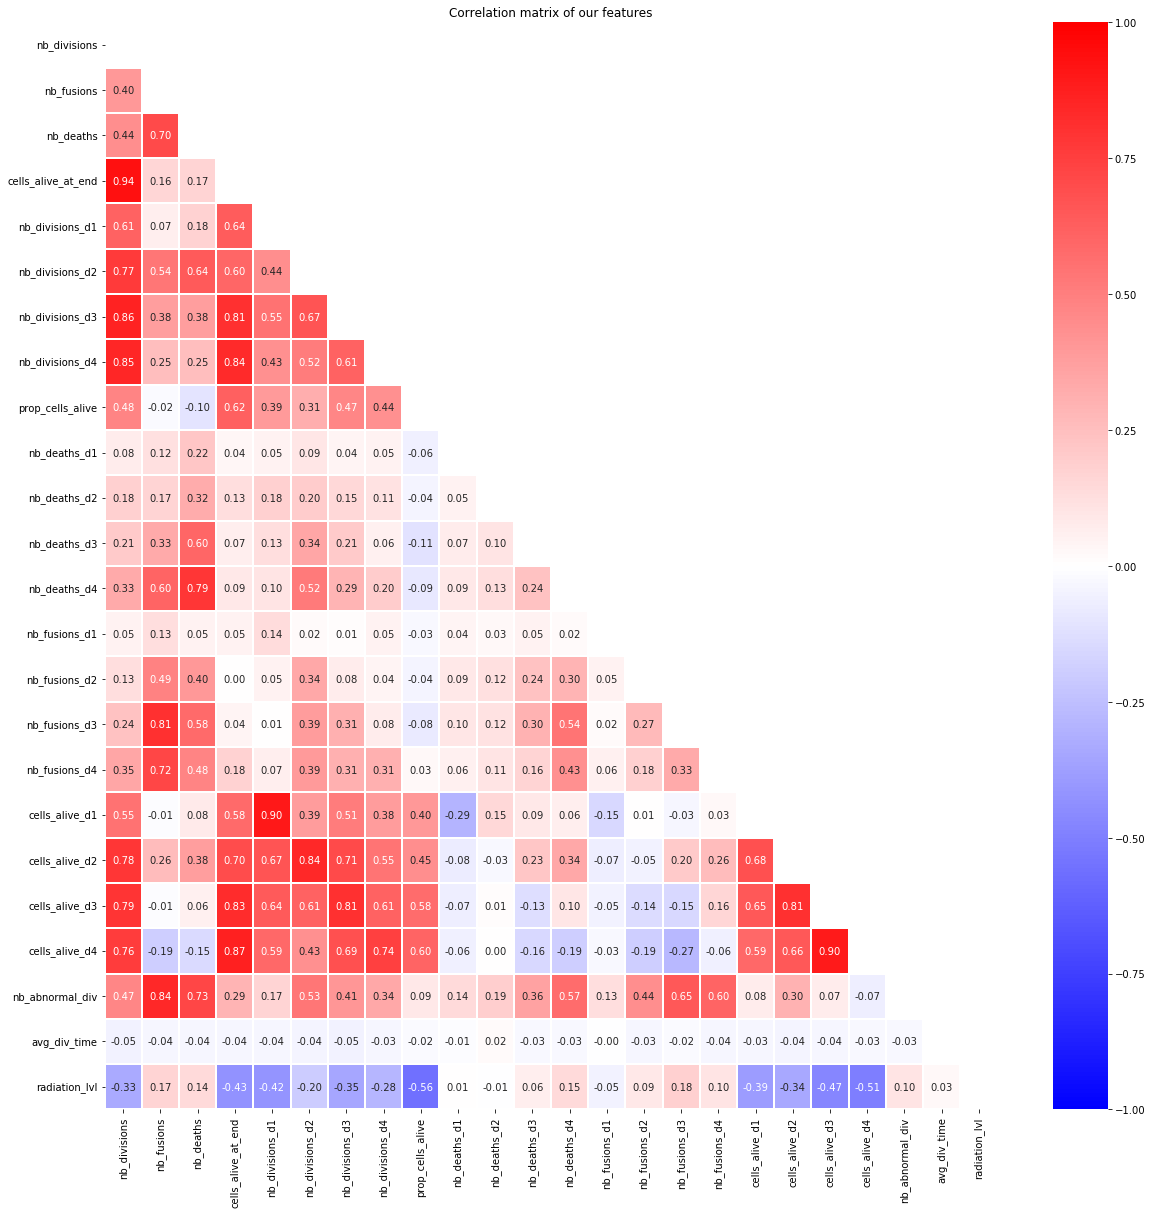

In [63]:
corr_matrix = cl.corr()

plt.figure(figsize=(20,20))
mask = np.triu(np.ones_like(corr_matrix))
heat_map = sns.heatmap( corr_matrix, linewidth = 1 , annot=True, mask=mask, vmin=-1,vmax=1,cmap = 'bwr', fmt=".2f")

plt.title( "Correlation matrix of our features" )
plt.show()